## 近似差分隐私

### 高斯机制
近似差分隐私拥有和纯粹
-差分隐私相似的特性。它同样满足串行组合性：

如果F1(x)满足(a1,b1)-差分隐私
同时F2(x)满足(a2,b2)-差分隐私
则发布两个结果的机制G(x) = (F1(x),F2(x))满足(a1+a2,b1+b2)-差分隐私
与纯粹ε-差分隐私相比，近似差分隐私串行组合性唯一的不同之处在于需要分别对λ和ε相加。近似差分隐私同样满足后处理性和并行组合性。

### 高斯机制

\begin{align}
F(x) = f(x) + \mathcal{N}(\sigma^2)\\
\text{where } \sigma^2 = \frac{2s^2 \log(1.25/\delta)}{\epsilon^2}
\end{align}

其中s是f的敏感度，$\mathcal{N}(\sigma^2)表示均值为0，方差为$$\sigma^2$的高斯（正态）分布采样结果。请注意，这里的log表示自然对数（本书其他地方出现的log同样表示自然对数）。

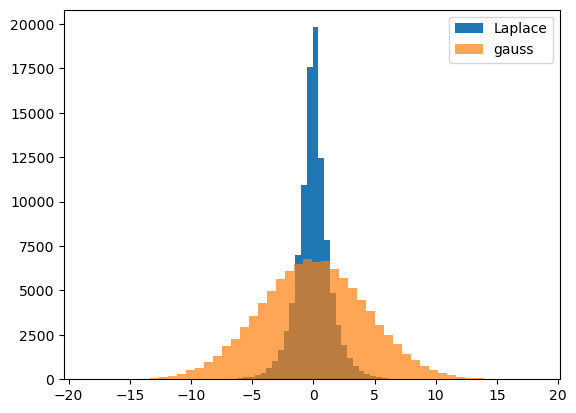

In [9]:
import numpy as np
import matplotlib.pyplot as plt

epsilon = 1
vals_laplace = [np.random.laplace(loc=0, scale=1/epsilon) for x in range(100000)]

delta = 10e-5
sigma = np.sqrt(2 * np.log(1.25 / delta)) * 1 / epsilon
vals_gauss = [np.random.normal(loc=0, scale=sigma) for x in range(100000)]

plt.hist(vals_laplace, bins=50, label='Laplace')
plt.hist(vals_gauss, bins=50, alpha=.7, label='gauss')
plt.legend();

与拉普拉斯机制的曲线相比，高斯机制的曲线看起来更”平”。当应用高斯机制时，我们更有可能得到远离真实值的差分隐私输出结果，而拉普拉斯机制的输出结果与真实值更接近一些（相比之下，拉普拉斯机制的曲线看起来更”尖”）。

因此，高斯机制有两个严重的缺点：其一，该机制需要使用宽松的-差分隐私定义；其二，该机制的准确性不如拉普拉斯机制。既然如此，为什么我们还需要高斯机制呢？

### 高级组合性

差分隐私引入了差分隐私机制串行组合性的一种新分析方法，此分析方法可以进一步降低隐私消耗量
高级组合定理[7]通常用k-折叠适应性组合（k-fold Adaptive Composition）机制来描述。k-折叠适应性组合指的是将一系列机制m1,m2,...,mi组合起来，这些机制满足下述条件：

`适应性：可以根据所有前述机制m1,m2,...,mi-1的输出来选择下一个机制mi`
`组合性：每个机制mi的输入既包括隐私数据集，也包括前述机制的所有输出`

In [10]:
# 此攻击针对的是敏感度为1的问询
def avg_attack(query, epsilon, k):
    results = [query + np.random.laplace(loc=0, scale=1/epsilon) for i in range(k)]
    return np.mean(results)

avg_attack(10, 1, 500)

10.08778382158617

在这个例子中，我们提前确定好了机制的组合顺序（我们每次都使用相同的机制），且k=500.
标准串行组合定理称，该机制的总隐私消耗量为kε（本例的总隐私消耗量为500ε）。

$$设 ( \epsilon_1, \epsilon_2, …, \epsilon_k )$$ 是 k 个随机噪声机制的隐私参数，每个机制满足$$ ( (\epsilon_1, \delta_1)-\text{差分隐私}, (\epsilon_2, \delta_2)-\text{差分隐私}, …, (\epsilon_k, \delta_k)-\text{差分隐私} )。$$
令 $$( \epsilon = \sum_{i=1}^{k} \epsilon_i ) 且 ( \delta = \max_{1 \leq i \leq k} \delta_i )。$$

则对于任意的查询序列$$ ( Q = (q_1, q_2, …, q_k) )，组合机制 ( M ) 满足 ( (\epsilon, \delta)-\text{差分隐私} )$$。

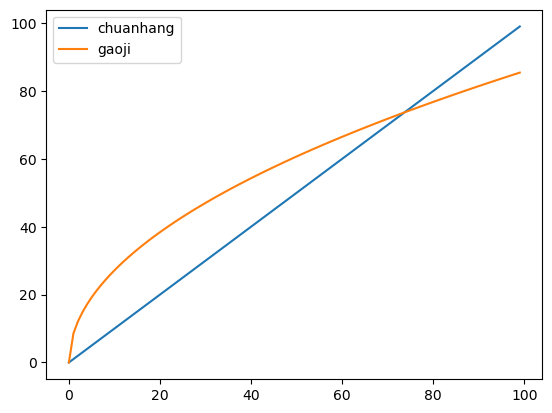

In [11]:
epsilon = 1
delta = 10e-5

def adv_comp(k):
    return 2*epsilon*np.sqrt(2*k*np.log(1/delta))

def seq_comp(k):
    return k*epsilon

plt.plot([seq_comp(k) for k in range(100)], label='chuanhang')
plt.plot([adv_comp(k) for k in range(100)], label='gaoji')
plt.legend();

事实证明，当k小于70时，标准的串行组合性比高级组合性得到的总隐私消耗量更小。因此，仅当k比较大时（如大于100时），高级组合性才会有用武之地。不过，当k非常大时，高级组合性可以显露出巨大的优势。

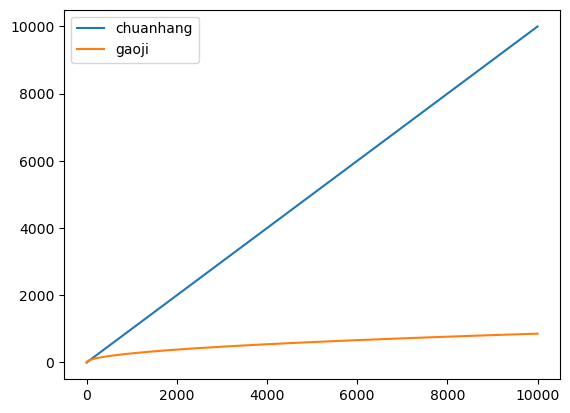

In [12]:
plt.plot([seq_comp(k) for k in range(10000)], label='chuanhang')
plt.plot([adv_comp(k) for k in range(10000)], label='gaoji')
plt.legend();

### 近似差分隐私的高级组合性

\begin{align}
\epsilon' = 2\epsilon \sqrt{2k \log(1/\delta')}
\end{align}

### 局部敏感度和全局敏感度区别：

局部敏感度：

局部敏感度是针对单个查询函数的。
它描述了当输入数据集中的一个个体发生变化时，查询结果的变化程度。
通常用 $( \Delta f )$ 表示，表示查询函数 $( f ) $的局部敏感度。
例如，对于一个查询函数 $( f )$，其局部敏感度表示为 $( \Delta f )$，表示在输入数据集中添加或删除一个个体后，查询结果的最大变化量。

全局敏感度：

全局敏感度是针对整个查询算法的。
它描述了在所有可能的输入数据集上，查询结果的最大变化程度。
通常用 $( \Delta M )$表示，表示查询算法 $( M )$ 的全局敏感度。
全局敏感度可以通过对所有可能的输入数据集进行极大化来计算，或者通过局部敏感度的最大值来计算。

局部敏感度用于衡量单个查询函数的敏感性，而全局敏感度则用于衡量整个查询算法的敏感性。在差分隐私中，通常关注的是全局敏感度，因为差分隐私的目标是保护整个数据集的隐私，而不仅仅是单个查询的隐私。

#### 均值问询的局部敏感度

均值问询的输出结果依赖于数据集的大小。从数据集中增加或删除数据行，数据集的大小将随之变化，导致均值问询的输出结果发生变化。

我们考虑最糟糕的情况：添加一个包含最大值（$u$）的新数据行。令$n = |x|$（即表示数据集的大小）。我们先考虑实际数据集的均\begin{align}
f(x) =& \frac{\sum_{i=1}^{n} x_i}{n}
\end{align}
现在，我们考虑添加一行后会发生什么:
\begin{align}
| f(x') - f(x) | = & \bigg| \frac{\sum_{i=1}^{n} x_i + u}{n+1} - \frac{\sum_{i=1}^{n} x_i}{n} \bigg| \\
\leq& \bigg| \frac{\sum_{i=1}^{n} x_i + u}{n+1} - \frac{\sum_{i=1}^{n} x_i}{n+1} \bigg| \\
=& \bigg| \frac{\sum_{i=1}^{n} x_i + u - \sum_{i=1}^{n} x_i}{n+1}\bigg| \\
=& \bigg| \frac{u}{n+1} \bigg| \\
\end{align}
此问询的局部敏感度依赖于实际数据集的大小，而全局敏感度的定义不可能与数据集本身相关。

### 通过局部敏感度实现差分隐私？

我们已经定义了一种新的敏感度指标，但我们该如何使用它呢？我们可以像全局敏感度那样直接使用拉普拉斯机制吗？以下对F的定义满足ε-差分隐私性吗？
\begin{align}
F(x) = f(x) + \mathsf{Lap}\left(\frac{LS(f,x)}{\epsilon}\right)
\end{align}
不满足！很不幸，答案是否定的。由于$LS(f, x)$本身与数据集相关，如果分析者知道某个问询在特定数据集下的局部敏感度，那么分析者也许能够推断出一些与数据集相关的信息。因此，不可能直接使用局部敏感度来满足差分隐私。举例来说，考虑前面定义的均值问询局部敏感度边界。如果我们知道特定数据集$x$的局部敏感度，我们就可以推断出没有噪声的情况下数据集$x$的准确行数
\begin{align}
\ |x| = \frac{b}{LS(f, x)} - 1
\end{align}

### “建议-测试-发布”框架

“建议-测试-发布”（Propose-Test-Release）框架[9]采用的就是此种方法。该框架首先询问数据分析者函数的建议（Propose）局部敏感度上界。随后，该框架执行满足差分隐私的测试（Test），检验所问询的数据集是否”远离”了局部敏感度高于建议边界的数据集。如果测试通过，该框架发布（Release）噪声结果，并将噪声量校准到建议的边界。

让我们来实现均值问询的”建议-测试-发布”框架吧。回想一下，该问询的局部敏感度是$\big|\frac{u}{n+1}\big|$；提高此局部敏感度的最好方法是减小$n$。如果我们以数据集$x$为出发点执行$k$步，得到的局部敏感度就会变为$\big|\frac{u}{(n-k)+1}\big|$
我们使用如下Python代码实现该框架

In [25]:
import numpy as np
import pandas as pd

adult = pd.read_csv('adult_with_pii.csv')
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity/epsilon)
def ls_at_distance(df, u, k):
    return np.abs(u/(len(df) - k + 1))

def dist_to_high_ls(df, u, b):
    k = 0
    
    while ls_at_distance(df, u, k) < b:
        k += 1
    
    return k

In [26]:
def ptr_avg(df, u, b, epsilon, delta, logging=False):
    df_clipped = df.clip(upper=u)
    k = dist_to_high_ls(df_clipped, u, b)

    noisy_distance = laplace_mech(k, 1, epsilon)
    threshold = np.log(2/delta)/(2*epsilon)

    if logging:
        print(f"噪声距离为{noisy_distance}，而门限值为{threshold}")

    if noisy_distance >= threshold:
        return laplace_mech(df_clipped.mean(), b, epsilon)
    else:
        return None

In [27]:
df = adult['Age']
u = 100                    # 设置年龄的上界为100
epsilon = 1                # 设置ε = 1
delta = 1/(len(df)**2)     # 设置δ = 1/n^2
b = 0.005                  # 建议敏感度为0.005

ptr_avg(df, u, b, epsilon, delta, logging=True)

噪声距离为12564.767323486163，而门限值为10.737505543744179


41.778680998822395

In [29]:
def gs_avg(df, u, epsilon):
    df_clipped = df.clip(upper=u)
    
    noisy_sum = laplace_mech(df_clipped.sum(), u, .5*epsilon)
    noisy_count = laplace_mech(len(df_clipped), 1, .5*epsilon)
    
    return noisy_sum / noisy_count

In [30]:
gs_avg(adult['Age'], u, epsilon)

41.77029537156513

### 平滑敏感度

1.设置$\beta = \frac{\epsilon}{2\log(2/\delta)}$
2.令$S = \max_{k = 1, \dots, n} e^{-\beta k} A(f, x, k)$
3.发布$f(x) + \mathsf{Lap}\left(\frac{2S}{\epsilon}\right)$
平滑敏感度的基本思想是不使用局部敏感度本身，而是使用局部敏感度的”平滑”近似值来校准噪声。使用平滑量的目的就是要防止因直接使用局部敏感度而意外发布数据集的有关信息。

缺点：
1、平滑敏感度通常比局部敏感度大（至少为2倍，详见步骤3），因此增加的噪声量可能会比”建议-测试-发布”等替代框架更大
2、计算平滑敏感度时需要找到所有可能的$k$中最大的平滑敏感度，这可能涉及极大的计算开销

最终敏感度: 0.006141751627564181


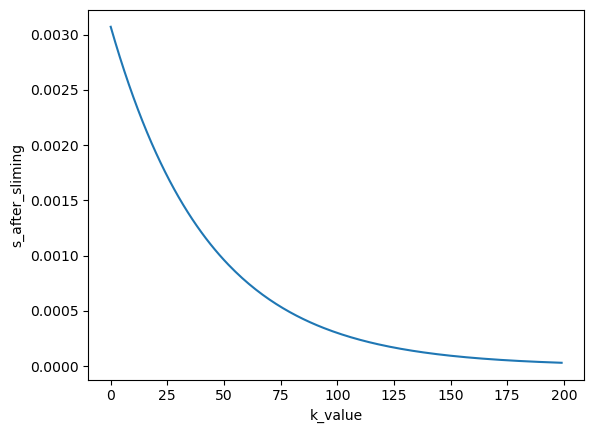

In [28]:
df = adult['Age']
epsilon = 1           # 设置ε = 1
delta = 1/len(df)**2  # 设置δ = 1/n^2

# 步骤1：设置β
beta = epsilon / (2*np.log(2/delta))

# 步骤2：对于不同的k值计算平滑后的局部敏感度
r = [np.exp(- beta * k) * ls_at_distance(df, u, k) for k in range(0,200)]
plt.plot(r);
plt.xlabel('k_value')
plt.ylabel('s_after_sliming');

S = np.max(r)
sensitivity = 2*S
print(f'最终敏感度: {sensitivity}')

这里需要注意到两个现象。第一，即使只考虑k小于200的情况，我们也可以清楚地看到，均值问询平滑局部敏感度随着k的增加而趋近于0。事实上，$k=0$时的均值问询平滑局部敏感度取得最大值。在多数情况下，平滑局部敏感度都会随着k的增加而降低。但是，如果想要使用平滑敏感度，我们就必须证明它（这里我们并没有给出证明）。第二，注意到我们增加到问询结果中的最终噪声量高于我们之前（在”建议-测试-发布”框架中）建议的敏感度。尽管这两个噪声量的差距不大，但这也表明使用”建议-测试-发布”得到的局部敏感度有可能低于平滑敏感度

### “采样-聚合”框架

对任意函数$f : D \rightarrow \mathbb{R}$，令裁剪上界和下界分别为$u$和$l$，则下述框架满足$\epsilon$-差分隐私：

1.将数据集$X \in D$拆分为$k$个不相交的数据块$x_1, \dots, x_k$
2.计算每个数据块的裁剪回复值：$a_i = \max(l, \min(u, f(x_i)))$
3.计算平均回复值并增加噪声：$A = \left(\frac{1}{k} \sum_{i=1}^k a_i \right) + \mathsf{Lap}\left(\frac{u - l}{k\epsilon}\right)$


In [32]:
def f(df):
    return df.mean()

def saa_avg_age(k, epsilon, logging=False):
    df = adult['Age']
    
    # 计算每个数据块应包含的行数
    chunk_size = int(np.ceil(df.shape[0] / k))
    
    if logging:
        print(f'数据块大小: {chunk_size}')
        
    # 步骤1：将`df`拆分为数据块
    xs      = [df[i:i+chunk_size] for i in range(0,df.shape[0],chunk_size)]
    
    # 步骤2：在每个x_i上执行f，并裁剪输出值
    answers = [f(x_i) for x_i in xs]
    
    u = 80
    l = 20
    clipped_answers = np.clip(answers, l, u)
    
    # 步骤3：计算输出均值，并增加噪声
    noisy_mean = laplace_mech(np.mean(clipped_answers), (u-l)/k, epsilon)
    return noisy_mean

saa_avg_age(600, 1, logging=True)

数据块大小: 55


42.10644655103783

该框架的关键参数是数据块数量，即k的取值。一方面，k越大，噪声均值的敏感度就越小。因此数据块数量越多，噪声量越小。另一方面，k越大，每个数据块就越小，因此每个回复值$f(x_i)$都越可能远离正确回复值$f(X)$。在上述例子中，我们希望每个数据块的平均年龄接近整个数据集的平均年龄。如果每个块只包含极少部分人，数据块的平均年龄很可能与数据集的平均年龄相差甚远。